In [2]:
import os
import django
from django.forms.models import model_to_dict

os.chdir('/Users/lavenderca/genomics_network/')
curr_dir = os.getcwd()

django.setup()

In [3]:
from django.contrib.auth.models import User

user = User.objects.all()[0]

In [4]:
from network import models
from analysis import correlation

#### Clean house

In [ ]:
models.Dataset.objects.all().delete()
models.MetaPlot.objects.all().delete()
models.IntersectionValues.objects.all().delete()

In [ ]:
import csv
import json

with open('notebooks/2016-11-01_metaplot_metadata.csv') as metadata:
    reader = csv.DictReader(metadata, delimiter=',')
    for r in reader:
        
        url = 'http://snpinfo.niehs.nih.gov/ucscview/andy/personal_files/' + r['bigWig']
        name = r['name']
        data_type = r['data_type']
        cell_type = r['cell_type']
        antibody = r['antibody']
        
        promoter_bed = curr_dir + '/data/genomic_regions/mm9_RefSeq_promoters.bed'
        enhancer_bed = curr_dir + '/data/genomic_regions/mm9_vista_enhancers.bed'
        
        promoter_gr = models.GenomicRegions.objects.filter(name__startswith='mm9_RefSeq_promoters')[0]
        enhancer_gr = models.GenomicRegions.objects.filter(name__startswith='mm9_RefSeq_enhancers')[0]
        
        promoter_intersection = curr_dir + '/data/intersections/' + r['header'] + '.promoters.intersection.json'
        enhancer_intersection = curr_dir + '/data/intersections/' + r['header'] + '.enhancers.intersection.json'
        
        promoter_metaplot = curr_dir + '/data/metaplots/' + r['header'] + '.promoters.metaplot.json'
        enhancer_metaplot = curr_dir + '/data/metaplots/' + r['header'] + '.enhancers.metaplot.json'
        
        with open(promoter_metaplot) as f:
            promoter_metaplot_obj = models.MetaPlot.objects.create(
                    genomic_regions = promoter_gr,
                    bigwig_url = url,
                    relative_start = -2500,
                    relative_end = 2499,
                    meta_plot = json.load(f),
                )
        with open(enhancer_metaplot) as f:
            enhancer_metaplot_obj = models.MetaPlot.objects.create(
                    genomic_regions = enhancer_gr,
                    bigwig_url = url,
                    relative_start = -2500,
                    relative_end = 2499,
                    meta_plot = json.load(f),
                )

        with open(promoter_intersection) as f:
            promoter_intersection_obj = models.IntersectionValues.objects.create(
                    genomic_regions = promoter_gr,
                    bigwig_url = url,
                    relative_start = -2500,
                    relative_end = 2499,
                    intersection_values = json.load(f),
                )
        with open(enhancer_intersection) as f:
            enhancer_intersection_obj = models.IntersectionValues.objects.create(
                    genomic_regions = enhancer_gr,
                    bigwig_url = url,
                    relative_start = -2500,
                    relative_end = 2499,
                    intersection_values = json.load(f),
                )

        models.Dataset.objects.create(
            data_type = data_type,
            cell_type = cell_type,
            antibody = antibody,
            ambiguous_url = url,
            name = name,
            slug = name,
            promoter_intersection = promoter_intersection_obj,
            enhancer_intersection = enhancer_intersection_obj,
            promoter_metaplot = promoter_metaplot_obj,
            enhancer_metaplot = enhancer_metaplot_obj,
        )

In [ ]:
models.CorrelationCell.objects.all().delete()

In [ ]:
all_datasets = models.Dataset.objects.all()

for i, d1 in enumerate(all_datasets):
    for d2 in all_datasets[i+1:]:
        if d1.promoter_intersection.genomic_regions.pk == \
                d2.promoter_intersection.genomic_regions.pk:
                
            intersection_1 = d1.promoter_intersection.intersection_values
            intersection_2 = d2.promoter_intersection.intersection_values
            gr_pk = d1.promoter_intersection.genomic_regions.pk
            gr = models.GenomicRegions.objects.get(pk=gr_pk)
            
            corr = correlation.Correlation(intersection_1, intersection_2)
            score = abs(corr.get_correlation()[0])
            
            models.CorrelationCell.objects.create(
                x_dataset = d1,
                y_dataset = d2,
                genomic_regions = gr,
                score = score,
            )
            
        
        if d1.enhancer_intersection.genomic_regions.pk == \
                d2.enhancer_intersection.genomic_regions.pk:
                
            intersection_1 = d1.enhancer_intersection.intersection_values
            intersection_2 = d2.enhancer_intersection.intersection_values
            gr_pk = d1.enhancer_intersection.genomic_regions.pk
            gr = models.GenomicRegions.objects.get(pk=gr_pk)

            corr = correlation.Correlation(intersection_1, intersection_2)
            score = abs(corr.get_correlation()[0])
            
            models.CorrelationCell.objects.create(
                x_dataset = d1,
                y_dataset = d2,
                genomic_regions = gr,
                score = score,
            )

In [ ]:
models.CorrelationCell.objects.all()[0].score

hg19_RefSeq_promoters
0
mm9_RefSeq_promoters
2701
hg19_RefSeq_enhancers
0
mm9_RefSeq_enhancers
2701


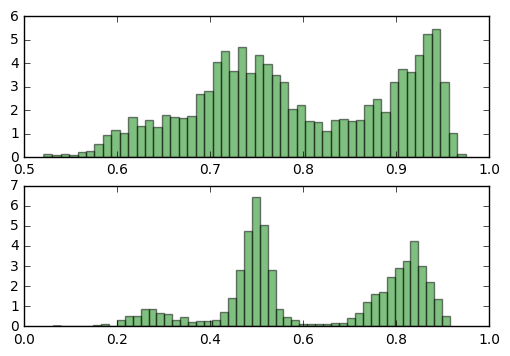

In [30]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt

count = 1

for gr in models.GenomicRegions.objects.all():
    scores = []
    x = None
    
    print(gr.name)
    print(len(models.CorrelationCell.objects.filter(genomic_regions=gr)))
    for corr in models.CorrelationCell.objects.filter(genomic_regions=gr):
        scores.append(corr.score)
        x = numpy.array(scores)
    
    if x is not None:
        plt.subplot(2, 1, count)
        plt.hist(x, 50, normed=1, facecolor='green', alpha=0.5)
    #     plt.show()
        count += 1

In [ ]:
models.Dataset.objects.all()[0].pk

In [ ]:
user = User.objects.all()[0]
print(user)

In [ ]:
my_user = models.MyUser.objects.all()[0]
for ds in models.Dataset.objects.all()[:5]:
    ds.owners.add(my_user)

In [ ]:
models.MyUser.objects.create(
    user = user,
    slug = user.username,
)

In [4]:
my_user = models.MyUser.objects.all()[0]

In [ ]:
for ds in models.Dataset.objects.all()[:5]:
    my_user.favorite_data.add(ds)

In [ ]:
models.Dataset.objects.filter(owners__in=[my_user.user])[0]

In [ ]:
for ds in models.Dataset.objects.all()[:5]:
    models.DataRecommendation.objects.create(
        owner = my_user,
        score = 0,
        recommended = ds,
        reference_dataset = models.Dataset.objects.filter(owners__in=[my_user.user])[0],
    )

In [ ]:
list(my_user.favorite_data.all())

In [ ]:
datasets = []
for dr in models.DataRecommendation.objects.filter(owner=my_user, hidden=False):
    print(dr.recommended.pk)

In [ ]:
for ds in models.Dataset.objects.all():
    ds.owners.clear()

In [ ]:
models.Dataset.objects.all()[0].get_absolute_url()

In [ ]:
models.Dataset.objects.get(name='testy_test_test').pk

In [ ]:
for ds in my_user.favorite_data.all():
    print(ds.id)

In [ ]:
models.MyUser.objects.all()[0].pk

In [13]:
for ds in models.Dataset.objects.all()[:15]:
    
    if not models.DataRecommendation.objects.filter(owner=my_user, recommended=ds).exists():
        models.DataFavorite.objects.create(
            owner = my_user,
            favorite = ds,
        )

In [14]:
for fav in models.DataFavorite.objects.all():
    print(fav.favorite.pk)

540
541
542
543
544
545
546
547
548
522


In [15]:
from django.contrib.auth.models import User

In [16]:
user=User.objects.create_user('morrissey', password='morrissey')
user.save()
models.MyUser.objects.create(
    user = user,
    slug = user.username,
)

user=User.objects.create_user('johnnymar', password='johnnymar')
user.save()
models.MyUser.objects.create(
    user = user,
    slug = user.username,
)

<MyUser: MyUser object>

In [17]:
for user in models.MyUser.objects.all():
    print(user.user.username)

lavenderca
morrissey
johnnymar


In [23]:
user_1 = models.MyUser.objects.get(slug='lavenderca')
for slug in ['morrissey', 'johnnymar']:
    user_2 = models.MyUser.objects.get(slug=slug)
    models.UserRecommendation.objects.create(
        owner = user_1,
        score = 0,
        recommended = user_2,
    )

In [25]:
for r in models.UserRecommendation.objects.all():
    print('{}: {}'.format(r.owner.slug, r.recommended.slug))

lavenderca: johnnymar
lavenderca: morrissey


In [31]:
models.Dataset.objects.all()[0].ambiguous_url

'http://snpinfo.niehs.nih.gov/ucscview/andy/personal_files/wgEncodeSydhTfbsCh12Mxi1af4185IggrabSig.bigWig'

In [44]:
for annotation in models.GeneAnnotation.objects.all():
    print(annotation.promoters)
#     promoter_region = models.GenomicRegions.objects.get(assembly=annotation.assembly, name__icontains='promoters')
#     enhancer_region = models.GenomicRegions.objects.get(assembly=annotation.assembly, name__icontains='enhancers')
#     annotation.promoters = promoter_region
#     annotation.enhancers = enhancer_region
#     annotation.save()

GenomicRegions object
GenomicRegions object


In [45]:
for region in models.GenomicRegions.objects.all():
    print(region.name)
    print(region.assembly)
    print(region.bed_file)

hg19_RefSeq_promoters
hg19
/Users/lavenderca/genomics_networkdata/genomic_regions/hg19_RefSeq_promoters.bed
mm9_RefSeq_promoters
mm9
/Users/lavenderca/genomics_networkdata/genomic_regions/mm9_RefSeq_promoters.bed
hg19_RefSeq_enhancers
hg19
/Users/lavenderca/genomics_networkdata/genomic_regions/hg19_vista_enhancers.bed
mm9_RefSeq_enhancers
mm9
/Users/lavenderca/genomics_networkdata/genomic_regions/mm9_vista_enhancers.bed


In [46]:
regions = models.GenomicRegions.objects.all()
for i, r in enumerate(regions):
    print(i)
    print(r.name)

0
hg19_RefSeq_promoters
1
mm9_RefSeq_promoters
2
hg19_RefSeq_enhancers
3
mm9_RefSeq_enhancers


In [47]:
regions[0].bed_file = '/Users/lavenderca/genomics_network/data/genomic_regions/hg19_RefSeq_promoters.bed'
regions[0].save()

regions[1].bed_file = '/Users/lavenderca/genomics_network/data/genomic_regions/mm9_RefSeq_promoters.bed'
regions[1].save()

regions[2].bed_file = '/Users/lavenderca/genomics_network/data/genomic_regions/hg19_vista_enhancers.bed'
regions[2].save()

regions[3].bed_file = '/Users/lavenderca/genomics_network/data/genomic_regions/mm9_vista_enhancers.bed'
regions[3].save()

In [62]:
import json
print(type(json.loads(models.Dataset.objects.get(name='blah').promoter_metaplot.meta_plot)))
print(type(models.Dataset.objects.get(name='wgEncodeSydhTfbsCh12Mxi1af4185IggrabSig').promoter_metaplot.meta_plot))

<class 'dict'>
<class 'dict'>


In [63]:
models.Dataset.objects.get(name='blah').delete()

(2,
 {'network.CorrelationCell': 0,
  'network.DataFavorite': 0,
  'network.DataRecommendation': 0,
  'network.Dataset': 1,
  'network.Dataset_owners': 1,
  'network.MyUser_favorite_data': 0})

In [10]:
added = 0
_user = User.objects.get(username='morrissey')
user = models.MyUser.objects.get(user=_user)

for ds in models.Dataset.objects.filter(owners=None):
    ds.owners.add(user)
    added += 1
    if added >= 5:
        break

In [19]:
me = models.MyUser.objects.get(user=User.objects.get(username='lavenderca'))

john = models.MyUser.objects.get(user=User.objects.get(username='johnnymar'))
sean = models.MyUser.objects.get(user=User.objects.get(username='morrissey'))

for ds in models.Dataset.objects.filter(owners__in=[john]):
    models.DataFavorite.objects.create(
        owner=me,
        favorite=ds,
    )

for ds in models.Dataset.objects.filter(owners__in=[sean])[:2]:
    models.DataFavorite.objects.create(
        owner=me,
        favorite=ds,
    )

In [20]:
for fav in models.DataFavorite.objects.filter(owner=me):
    for user in fav.favorite.owners.all():
        print(user.user.username)

johnnymar
johnnymar
johnnymar
johnnymar
johnnymar
morrissey
morrissey


In [18]:
models.DataFavorite.objects.all().delete()

(18, {'network.DataFavorite': 18})

In [21]:
models.UserRecommendation.objects.all().delete()

(2, {'network.UserRecommendation': 2})